In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')         
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

# model
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, LassoCV, BayesianRidge

from sklearn.metrics import roc_auc_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn.impute import KNNImputer
from sklearn.feature_extraction import FeatureHasher
from bayes_opt import BayesianOptimization

# neural network
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

%matplotlib inline

/Users/zhoujianyao/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Train = pd.read_csv('used_car_train_20200313.csv', sep=' ')
Test = pd.read_csv('used_car_testB_20200421.csv', sep=' ')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
Train = reduce_mem_usage(Train)
Test = reduce_mem_usage(Test)

Mem. usage decreased to 10.73 Mb (69.8% reduction)
Mem. usage decreased to  3.39 Mb (70.4% reduction)


In [5]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int32  
 1   name               150000 non-null  int32  
 2   regDate            150000 non-null  int32  
 3   model              149999 non-null  float16
 4   brand              150000 non-null  int8   
 5   bodyType           145494 non-null  float16
 6   fuelType           141320 non-null  float16
 7   gearbox            144019 non-null  float16
 8   power              150000 non-null  int16  
 9   kilometer          150000 non-null  float16
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int16  
 12  seller             150000 non-null  int8   
 13  offerType          150000 non-null  int8   
 14  creatDate          150000 non-null  int32  
 15  price              150000 non-null  int32  
 16  v_

In [6]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int32  
 1   name               50000 non-null  int32  
 2   regDate            50000 non-null  int32  
 3   model              50000 non-null  float16
 4   brand              50000 non-null  int8   
 5   bodyType           48496 non-null  float16
 6   fuelType           47076 non-null  float16
 7   gearbox            48032 non-null  float16
 8   power              50000 non-null  int16  
 9   kilometer          50000 non-null  float16
 10  notRepairedDamage  50000 non-null  object 
 11  regionCode         50000 non-null  int16  
 12  seller             50000 non-null  int8   
 13  offerType          50000 non-null  int8   
 14  creatDate          50000 non-null  int32  
 15  v_0                50000 non-null  float16
 16  v_1                500

In [ ]:
#profile = ProfileReport(Test)
#profile
#profile.to_file('output_test.html')

<AxesSubplot:xlabel='price'>

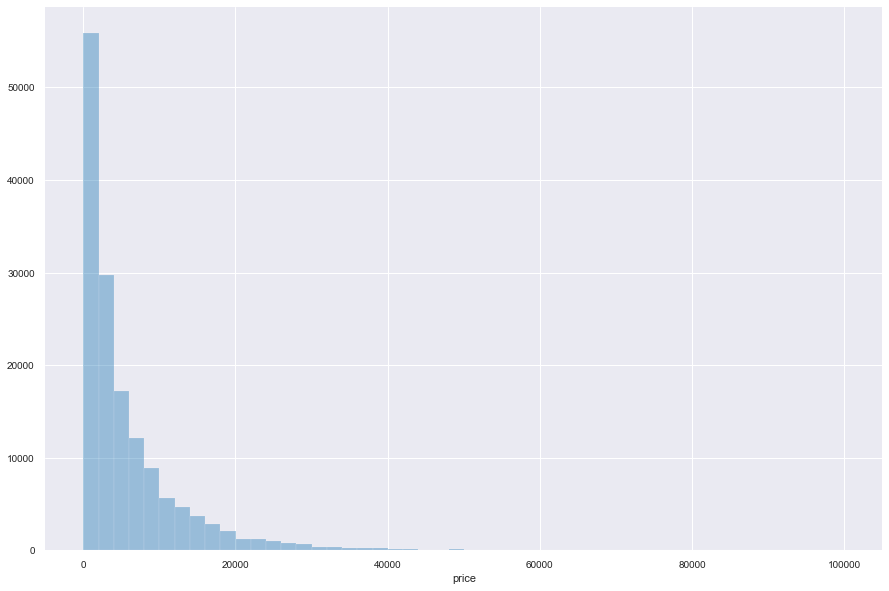

In [7]:
plt.figure(figsize=(15, 10))
sns.distplot(Train['price'], kde=False)

In [8]:
log_price, lamda = boxcox(Train['price'].values)
Train['price'] = list(log_price)

In [9]:
Test['price'] = -999
data = pd.concat([Train, Test], axis=0)
print(f'整个数据集的样本数量：{data.shape[0]}')

整个数据集的样本数量：200000


In [10]:
# 这样的话seller和offerType都是单属性特征了，直接删去吧
print(data.shape)
del data['seller']
del data['offerType']
print(data.shape)

(200000, 31)
(200000, 29)


In [11]:
(data['power'].value_counts().sort_index() / len(data)).cumsum()

0        0.086095
1        0.086145
2        0.086170
3        0.086185
4        0.086250
5        0.086535
6        0.086575
7        0.086605
8        0.086630
9        0.086635
10       0.086660
11       0.086730
12       0.086775
13       0.086790
14       0.086810
15       0.086845
16       0.086865
17       0.086885
18       0.086895
19       0.086910
20       0.086935
23       0.086950
24       0.086980
25       0.087010
26       0.087020
29       0.087035
30       0.087055
31       0.087070
32       0.087075
33       0.087190
34       0.087235
35       0.087240
36       0.087255
37       0.087370
38       0.087380
39       0.087665
40       0.088495
41       0.089750
42       0.089860
43       0.090180
44       0.091120
45       0.098655
46       0.098805
47       0.098885
48       0.099050
49       0.099090
50       0.110955
51       0.111210
52       0.112050
53       0.112585
54       0.127915
55       0.132920
56       0.133670
57       0.133925
58       0.144515
59       0

In [12]:
# power特征
def power_map(x):
    if x == 0:
        return 0
    elif 0<x<=100:
        return 1
    elif 100<x<=200:
        return 2
    elif 200<x<=300:
        return 3
    elif 300<x<=600:
        return 4

data['power'] = data['power'].apply(lambda x:x if x<=600 else 600)
data['power_cut'] = data['power'].apply(power_map)

In [13]:
def feat_mean(df, df_feature, fe, value, name=""):
    #根据fe分组，统计每个分组中value特征的平均值，然后再合并到原数据中
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].mean()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_mean" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_max(df, df_feature, fe, value, name=""):
    #根据fe分组，统计每个分组中value特征的平均值，然后再合并到原数据中
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].max()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_max" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_min(df, df_feature, fe, value, name=""):
    #根据fe分组，统计每个分组中value特征的平均值，然后再合并到原数据中
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].min()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_min" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_std(df, df_feature, fe, value, name=""):
    #根据fe分组，统计每个分组中value特征的平均值，然后再合并到原数据中
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].std()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_std" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_skew(df, df_feature, fe, value, name=""):
    #根据fe分组，统计每个分组中value特征的平均值，然后再合并到原数据中
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].skew()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_skew" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_count(df, df_feature, fe, value, name=""):
    #根据fe分组，统计每个分组中value特征的数量，然后再合并到原数据中
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].count()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_count" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_nunique(df, df_feature, fe, value, name=""):
    #根据fe分组，统计每个分组中value特征的不同值的个数，然后再合并到原数据中
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].nunique()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_nunique" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feature_count(data, df_feature, features=[]):
    new_feature = 'count'
    for i in features:
        new_feature += '_' + i
    try:
        del data[new_feature]
    except:
        pass
    temp = df_feature.groupby(features).size().reset_index().rename(columns={0: new_feature})
    data = data.merge(temp, 'left', on=features).fillna(0)
    return data

In [14]:
df_feature = data[data['price']!=-999]

In [15]:
#data['isknown_bodyType'] = data['bodyType'].apply(lambda x: 0 if pd.isnull(x) else 1)
data['bodyType'] = data['bodyType'].fillna(data['bodyType'].mode()[0])

In [16]:
#data['isknown_fuelType'] = data['fuelType'].apply(lambda x: 0 if pd.isnull(x) else 1)
data['fuelType'] = data['fuelType'].fillna(data['fuelType'].mode()[0])

In [17]:
#data['isknown_gearbox'] = data['gearbox'].apply(lambda x: 0 if pd.isnull(x) else 1)
data['gearbox'] = data['gearbox'].fillna(data['gearbox'].mode()[0])

In [18]:
#data['isknown_model'] = data['model'].apply(lambda x: 0 if pd.isnull(x) else 1)
data['model'] = data['model'].fillna(data['model'].mode()[0])

<AxesSubplot:xlabel='v_0'>

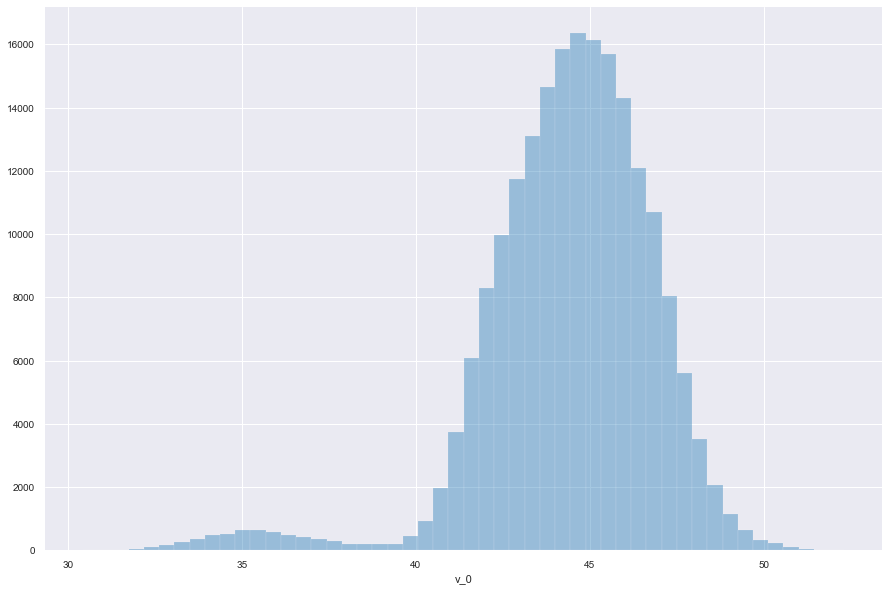

In [19]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_0'], kde=False)

In [20]:
data['v_0_diverce'] = np.where(data['v_0']<=39, 0, 1)
data['v_0_diverce'].value_counts()

1    194069
0      5931
Name: v_0_diverce, dtype: int64

<AxesSubplot:xlabel='v_1'>

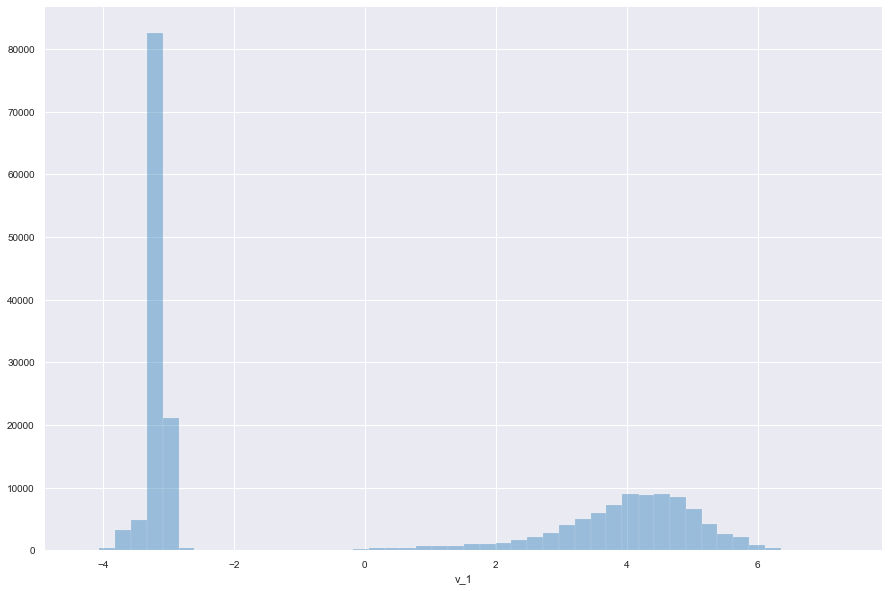

In [21]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_1'], kde=False)

In [22]:
data['v_1_diverce'] = np.where(data['v_1']<=-2, 0, 1)
data['v_1_diverce'].value_counts()

0    112599
1     87401
Name: v_1_diverce, dtype: int64

<AxesSubplot:xlabel='v_5'>

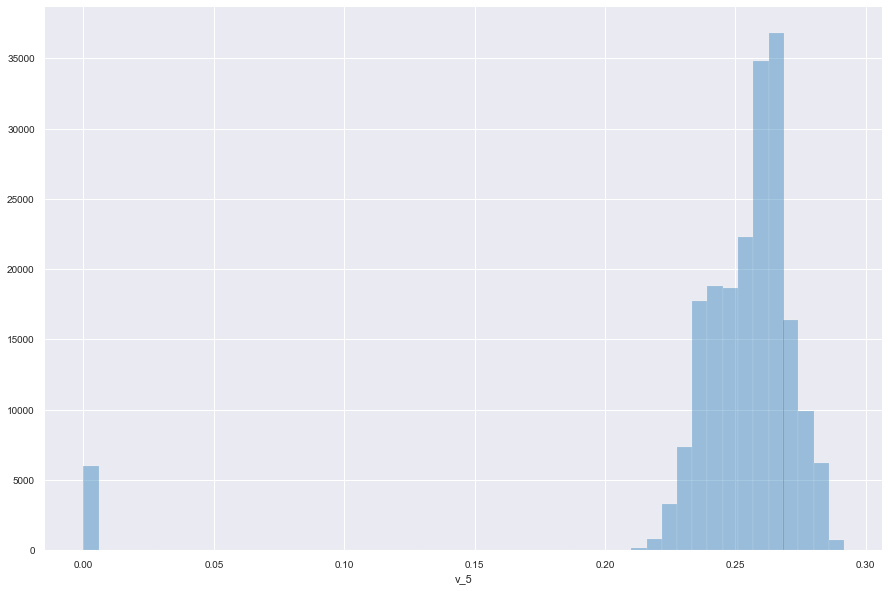

In [23]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_5'], kde=False)

In [24]:
data['v_5_diverce'] = np.where(data['v_5']<0.1, 0, 1)
data['v_5_diverce'].value_counts()

1    193990
0      6010
Name: v_5_diverce, dtype: int64

<AxesSubplot:xlabel='v_6'>

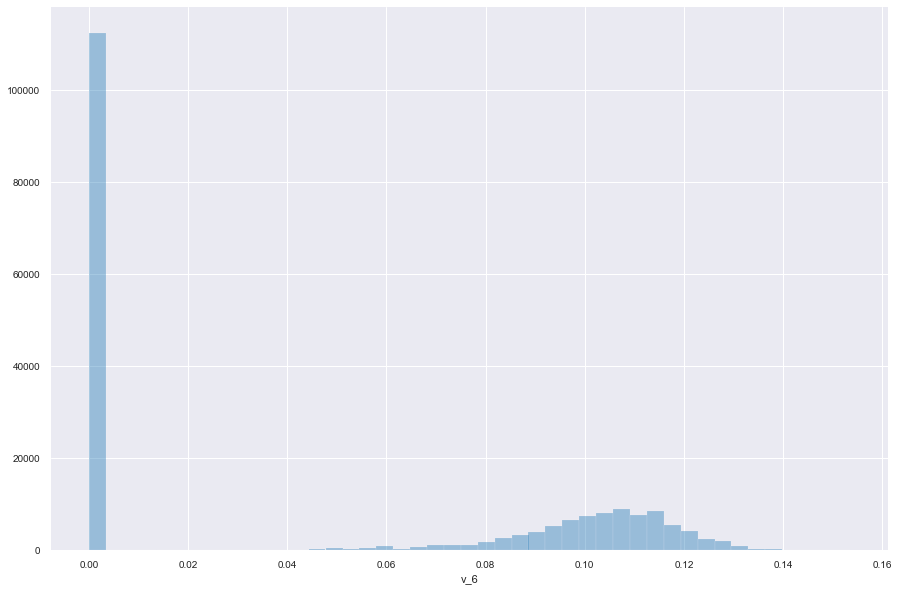

In [25]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_6'], kde=False)

In [26]:
#8.628845e-03与1.047516e-02有个突变
data['v_6_diverce'] = np.where(data['v_6']<0.01, 0, 1)
data['v_6_diverce'].value_counts()

0    112588
1     87412
Name: v_6_diverce, dtype: int64

<AxesSubplot:xlabel='v_7'>

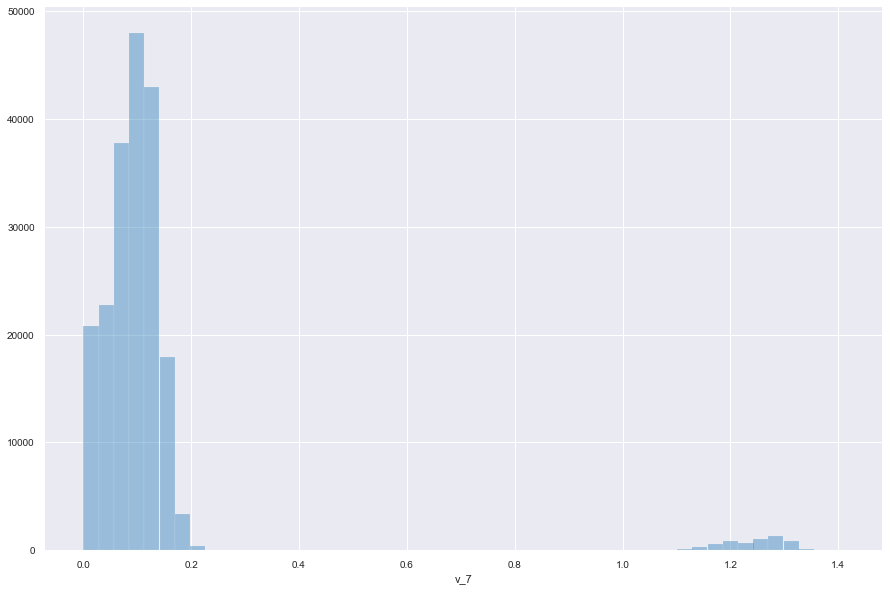

In [27]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_7'], kde=False)

In [28]:
data['v_7_diverce'] = np.where(data['v_7']<0.8, 0, 1)
data['v_7_diverce'].value_counts()

0    193990
1      6010
Name: v_7_diverce, dtype: int64

<AxesSubplot:xlabel='v_10'>

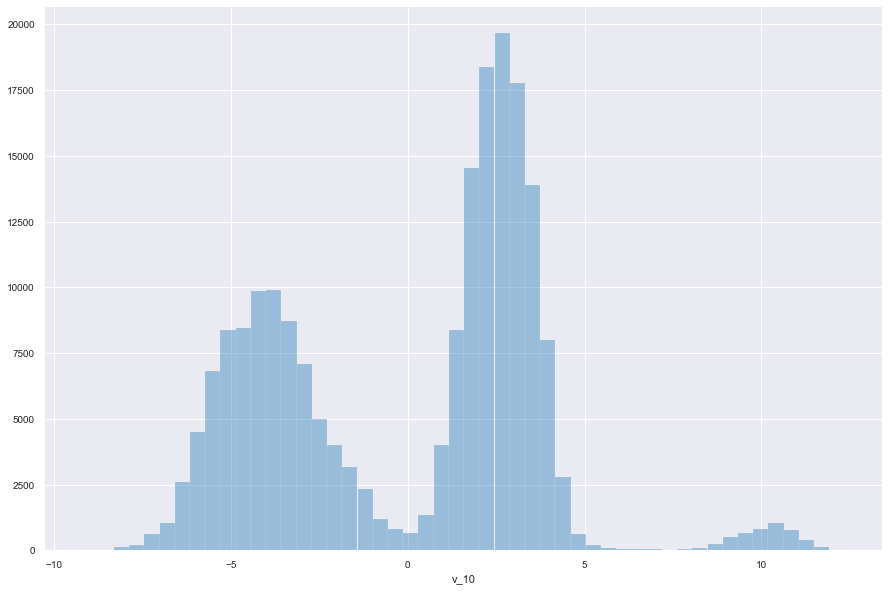

In [29]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_10'], kde=False)

In [30]:
data['v_10_diverce'] = np.where(data['v_10']<0, 0, np.where(data['v_10']<7.5, 1, 2))
data['v_10_diverce'].value_counts()

1    110373
0     84966
2      4661
Name: v_10_diverce, dtype: int64

<AxesSubplot:xlabel='v_11'>

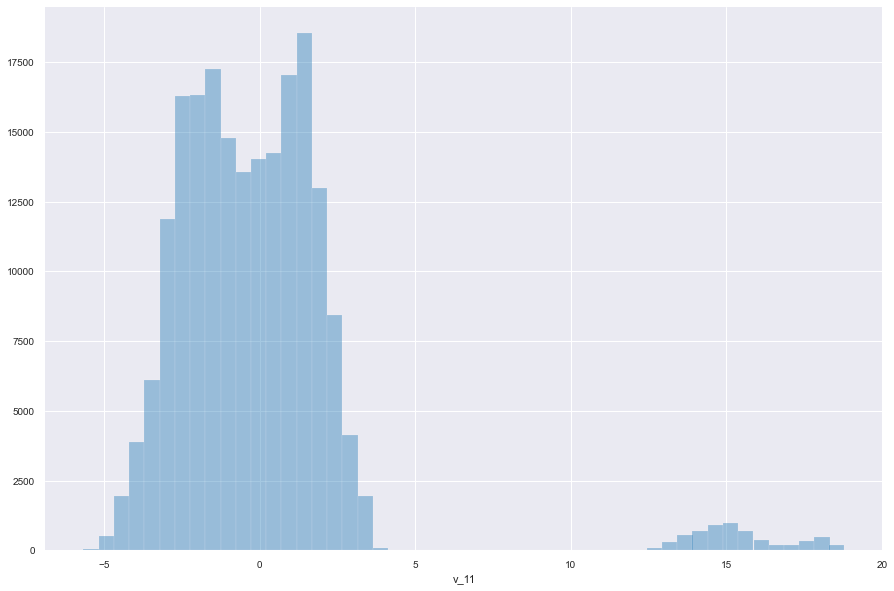

In [31]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_11'], kde=False)

In [32]:
data['v_11_diverce'] = np.where(data['v_11']<8, 0, 1)
data['v_11_diverce'].value_counts()

0    193990
1      6010
Name: v_11_diverce, dtype: int64

<AxesSubplot:xlabel='v_13'>

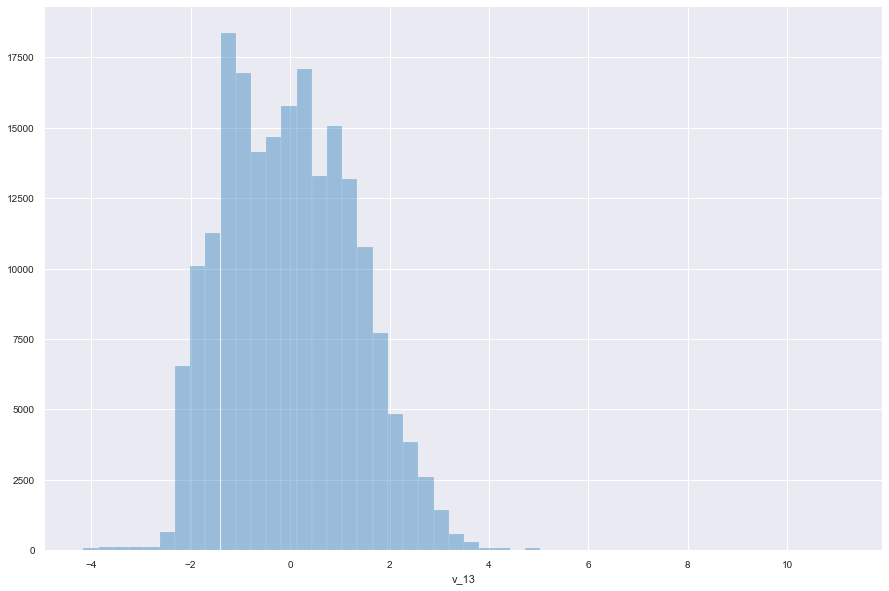

In [33]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_13'], kde=False)

<AxesSubplot:xlabel='v_14'>

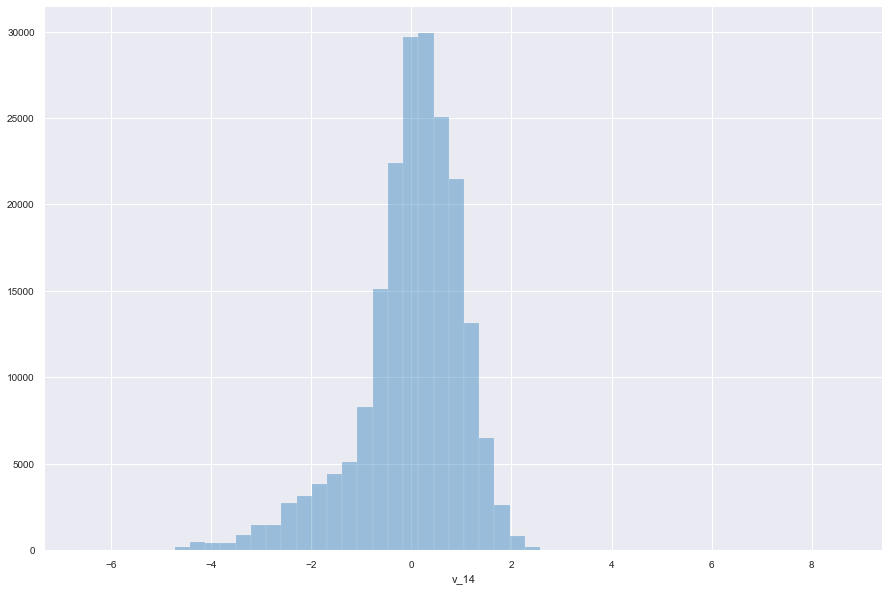

In [34]:
plt.figure(figsize=(15, 10))
sns.distplot(data['v_14'], kde=False)

In [35]:
# 有些时间是错误的，比如19950001，月份不可能为00，所以+100变成19950101
data['regDate'] = data['regDate'].apply(lambda x: x if str(x)[5]!='0' else x+100)

In [36]:
data['creatDate'] = pd.to_datetime(data['creatDate'], format='%Y%m%d')
data['regDate'] = pd.to_datetime(data['regDate'], format='%Y%m%d')
# 取出年、季度、月、日等时间特征
data['creatDate_year'] = data['creatDate'].dt.year
data['creatDate_month'] = data['creatDate'].dt.month
data['creatDate_day'] = data['creatDate'].dt.day
data['creatDate_quarter'] = data['creatDate'].dt.quarter
data['regDate_year'] = data['regDate'].dt.year
data['regDate_month'] = data['regDate'].dt.month
data['regDate_day'] = data['regDate'].dt.day
data['regDate_quarter'] = data['regDate'].dt.quarter

In [37]:
# 使用年限 = 总使用天数 / 365，保留一位小数
data['usedYears'] = round((data['creatDate'] - data['regDate']).dt.days / 365.0, 1)

In [38]:
# 众数填充
data['notRepairedDamage'] = data['notRepairedDamage'].replace('-', data['notRepairedDamage'].mode()[0])

In [39]:
data.isnull().sum()

SaleID               0
name                 0
regDate              0
model                0
brand                0
bodyType             0
fuelType             0
gearbox              0
power                0
kilometer            0
notRepairedDamage    0
regionCode           0
creatDate            0
price                0
v_0                  0
v_1                  0
v_2                  0
v_3                  0
v_4                  0
v_5                  0
v_6                  0
v_7                  0
v_8                  0
v_9                  0
v_10                 0
v_11                 0
v_12                 0
v_13                 0
v_14                 0
power_cut            0
v_0_diverce          0
v_1_diverce          0
v_5_diverce          0
v_6_diverce          0
v_7_diverce          0
v_10_diverce         0
v_11_diverce         0
creatDate_year       0
creatDate_month      0
creatDate_day        0
creatDate_quarter    0
regDate_year         0
regDate_month        0
regDate_day

In [40]:
data = feature_count(data, df_feature, ['name'])
del data['name']

In [41]:
# 平均每年行驶的里程数 = 总里程数 / 使用年限
data['km_per_year'] = data['kilometer'] / data['usedYears']

In [42]:
(data['km_per_year'].value_counts().sort_index()/len(data)).cumsum()

0.019763     0.000020
0.019841     0.000080
0.019920     0.000095
0.020000     0.000100
0.020080     0.000125
0.020161     0.000140
0.020243     0.000155
0.020325     0.000165
0.020408     0.000170
0.020492     0.000175
0.020576     0.000180
0.020661     0.000235
0.020747     0.000250
0.020833     0.000265
0.020921     0.000275
0.021008     0.000285
0.021097     0.000305
0.021186     0.000310
0.021368     0.000320
0.021459     0.000335
0.021552     0.000395
0.021645     0.000405
0.021739     0.000410
0.021834     0.000415
0.021930     0.000430
0.022026     0.000450
0.022124     0.000455
0.022222     0.000460
0.022321     0.000465
0.022422     0.000470
0.022523     0.000575
0.022624     0.000580
0.022727     0.000620
0.022831     0.000640
0.022936     0.000670
0.023041     0.000690
0.023256     0.000700
0.023364     0.000725
0.023474     0.000800
0.023585     0.001325
0.023697     0.001355
0.023810     0.001395
0.023923     0.001415
0.024038     0.001440
0.024155     0.001470
0.024272  

In [43]:
def km_per_year_cut(x):
    if x<=1:
        return 0
    elif 1<x<=3:
        return 1
    elif x>3:
        return 2
    
data['km_per_year_cut'] = data['km_per_year'].apply(km_per_year_cut)

In [44]:
data['v_13'] = data['v_13'].apply(lambda x: x if x<=6 else 6)
data['v_14'] = data['v_14'].apply(lambda x: x if x<=4 else 4)

In [45]:
def usedYears_cut(x):
    if x<5:
        return 0
    elif 5<=x<10:
        return 1
    elif 10<=x<15:
        return 2
    elif 15<=x<20:
        return 3
    elif x>=20:
        return 4
    
data['usedYears_cut'] = data['usedYears'].apply(usedYears_cut)

In [46]:
data.head()

SaleID    regDate  model  brand  bodyType  fuelType  gearbox  power  \
0       0 2004-04-02   30.0      6       1.0       0.0      0.0     60   
1       1 2003-03-01   40.0      1       2.0       0.0      0.0      0   
2       2 2004-04-03  115.0     15       1.0       0.0      0.0    163   
3       3 1996-09-08  109.0     10       0.0       0.0      1.0    193   
4       4 2012-01-03  110.0      5       1.0       0.0      0.0     68   

   kilometer notRepairedDamage  regionCode  creatDate      price       v_0  \
0       12.5               0.0        1046 2016-04-04  10.397713  43.34375   
1       15.0               0.0        4366 2016-03-09  11.664249  45.31250   
2       12.5               0.0        2806 2016-04-02  12.758106  45.96875   
3       15.0               0.0         434 2016-03-12  10.884682  45.68750   
4        5.0               0.0        6977 2016-03-13  12.393979  44.37500   

        v_1       v_2       v_3       v_4       v_5       v_6       v_7  \
0  3.966797  0.050262  2.160156  1.143555  0.235718  0.101990  0.129517   
1  5.234375  0.137939  1.380859 -1.421875  0.264893  0.121033  0.135742   
2  4.824219  1.319336 -0.998535 -0.997070  0.251465  0.114929  0.165161   
3  4.492188 -0.050629  0.883789 -2.228516  0.274414  0.110291  0.121948   
4  2.031250  0.572266 -1.571289  2.246094  0.228027  0.073181  0.091858   

        v_8       v_9      v_10      v_11      v_12      v_13      v_14  \
0  0.022812  0.097473 -2.880859  2.804688 -2.419922  0.795410  0.914551   
1  0.026596  0.020584 -4.902344  2.095703 -1.030273 -1.722656  0.245483   
2  0.062164  0.027069 -4.847656  1.803711  1.565430 -0.832520 -0.229980   
3  0.033386  0.000000 -4.507812  1.286133 -0.501953 -2.437500 -0.478760   
4  0.078796  0.121521 -1.896484  0.910645  0.931152  2.833984  1.923828   

   power_cut  v_0_diverce  v_1_diverce  v_5_diverce  v_6_diverce  v_7_diverce  \
0          1            1            1            1            1            0   
1          0            1            1            1            1            0   
2          2            1            1            1            1            0   
3          2            1            1            1            1            0   
4          1            1            1            1            1            0   

   v_10_diverce  v_11_diverce  creatDate_year  creatDate_month  creatDate_day  \
0             0             0            2016                4              4   
1             0             0            2016                3              9   
2             0             0            2016                4              2   
3             0             0            2016                3             12   
4             0             0            2016                3             13   

   creatDate_quarter  regDate_year  regDate_month  regDate_day  \
0                  2          2004              4            2   
1                  1          2003              3            1   
2                  2          2004              4            3   
3                  1          1996              9            8   
4                  1          2012              1            3   

   regDate_quarter  usedYears  count_name  km_per_year  km_per_year_cut  \
0                2       12.0        78.0     1.041667                1   
1                1       13.0        19.0     1.153846                1   
2                2       12.0         2.0     1.041667                1   
3                3       19.5         2.0     0.769231                0   
4                1        4.2         1.0     1.190476                1   

   usedYears_cut  
0              2  
1              2  
2              2  
3              3  
4              0

In [47]:
data.to_csv('data/raw_data_0927.csv', index=False)

In [48]:
data = pd.read_csv("data/raw_data_0927.csv")

In [49]:
data['city'] = data['regionCode'].apply(lambda x: str(x)[:2])

In [50]:
del data['regionCode']

In [51]:
data_feature = data[data['price']!=-999]

In [52]:
data[data['price']!=-999].corr()['price'].sort_values()

v_3                 -0.926946
usedYears           -0.748826
usedYears_cut       -0.733816
kilometer           -0.394459
v_11                -0.362474
v_10                -0.357392
notRepairedDamage   -0.259121
v_9                 -0.235163
v_4                 -0.162262
v_11_diverce        -0.156346
v_7_diverce         -0.156346
v_7                 -0.136624
v_10_diverce        -0.123989
brand               -0.077777
count_name          -0.071600
creatDate_year      -0.004111
regDate_day         -0.002556
creatDate_day       -0.002540
SaleID               0.000314
creatDate_month      0.017758
creatDate_quarter    0.020062
v_13                 0.037211
v_2                  0.043518
v_1_diverce          0.064917
v_6_diverce          0.064935
v_14                 0.070206
regDate_quarter      0.099304
regDate_month        0.110771
v_1                  0.122520
v_6                  0.127693
model                0.129540
v_5_diverce          0.156346
v_0_diverce          0.170468
v_5       

In [53]:
%%time
# 根据重要的类别特征提取关于标签price的新特征（分组后的mean、max、min、skew、std等）
cat_col = ['model', 'brand', 'bodyType', 'fuelType', 'usedYears_cut',
            'gearbox', 'power_cut', 'kilometer', 'notRepairedDamage', 'city',
            'regDate_year', 'km_per_year_cut', ]

for i in cat_col:
    for j in ['price']:
        data = feat_mean(data, data_feature, [i], j)
        data = feat_max(data, data_feature, [i], j)
        data = feat_min(data, data_feature, [i], j)
        data = feat_skew(data, data_feature, [i], j)
        data = feat_std(data, data_feature, [i], j)

# 重要类别特征之间的交互（分组后的count、nunique等）
count_col = ['usedYears_cut', 'kilometer', 'km_per_year_cut', 'power_cut', 'regDate_year']
# cache存放已经处理过的变量
cache1 = []
for i in count_col:
    for j in count_col:
        if i+"_"+j+"count" not in cache1 and i!=j:
            data = feat_count(data, data_feature, [i], j)
            data = feat_nunique(data, data_feature, [i], j)
            cache1.append(i+"_"+j+"count")
        elif i+"_"+j+"count" not in cache1 and i==j:
            data = feature_count(data, data_feature, [i])
        
cross = ['v_3', 'v_0', 'v_12', 'v_8', 'usedYears']
numeric = ['v_0', 'v_3', 'v_8', 'v_12']
cache2 = []

# 特征相乘建立新特征
for i in cross:
    for j in cross:
        if (i+"*"+j not in cache2) and (j+"*"+i not in cache2):
            data[i+"*"+j] = data[i] * data[j]
            cache2.append(i+"*"+j)
# 特征相加建立新特征
for i in numeric:
    for j in numeric:
        if (i+"+"+j not in cache2) and (j+"+"+i not in cache2):
            data[i+"+"+j] = data[i] + data[j]
            cache2.append(i+"+"+j)
# 特征相减建立新特征            
for i in numeric:
    for j in numeric:
        if (i+"-"+j not in cache2) and (j+"-"+i not in cache2):
            data[i+"-"+j] = data[i] - data[j]
            cache2.append(i+"-"+j)

CPU times: user 3min 7s, sys: 14 s, total: 3min 21s
Wall time: 47.3 s


In [54]:
data.drop(['SaleID', 'regDate', 'creatDate'], axis=1, inplace=True)
data.drop(['v_0-v_0', 'v_3-v_3', 'v_8-v_8', 'v_12-v_12', 'v_0+v_0', 'v_3+v_3', 'v_8+v_8', 'v_12+v_12'], axis=1, inplace=True)

In [55]:
print(f"before: {data.shape[1]}")
for col in data.columns:
    if data[col].nunique() == 1:
        del data[col]
        
print(f"after: {data.shape[1]}")

before: 178
after: 167


In [56]:
data.to_csv('data/cleaned_data_0927.csv', index=False)

In [57]:
cleaned_data = pd.read_csv('data/cleaned_data_0927.csv')

In [58]:
cat_feature = ['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage',
               'power_cut', 'regDate_year', 'km_per_year_cut', 'v_0_diverce',
                'v_1_diverce', 'v_5_diverce', 'v_6_diverce', 'v_7_diverce',
                'v_10_diverce', 'v_11_diverce', 'km_per_year_cut', 'city',
               'creatDate_month', 'usedYears_cut', 'creatDate_quarter', 'regDate_month',
               'regDate_quarter', 'usedYears_cut']

cleaned_data[cat_feature] = cleaned_data[cat_feature].astype(int)

In [59]:
train_data = cleaned_data[cleaned_data['price'] != -999]
test_data = cleaned_data[cleaned_data['price'] == -999].drop(['price'], axis=1)

In [60]:
X_train = train_data.drop(['price'], axis=1)
Y_train = train_data['price']
# filterd features

In [61]:
print(X_train.shape)
print(Y_train.shape)
print(test_data.shape)

(150000, 166)
(150000,)
(50000, 166)


In [62]:
from sklearn.feature_selection import RFE
import time

model = lgb.LGBMRegressor(n_estimators=1000, n_jobs=-1)
rfe = RFE(model, 101, verbose=1)
start = time.time()
RFE_X_train = rfe.fit_transform(X_train, Y_train)
RFE_test_data = rfe.transform(test_data)
print(time.time() - start)

Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
F

In [63]:
choosed_X_train = X_train.loc[:, list(rfe.get_support())]
choosed_feature = X_train.loc[:, list(rfe.get_support())].columns

In [64]:
choosed_test_data = test_data.loc[:, list(rfe.get_support())]

In [57]:
%%time

def lgb_bayesian(n_estimators,
                 learning_rate,
                 max_depth,
                 subsample,
                 colsample_bytree,
                 min_child_samples,
                 min_child_weight,
                 reg_alpha,
                 reg_lambda):
    
    min_child_samples = int(min_child_samples)
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    lgb_model = lgb.LGBMRegressor(
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  learning_rate=learning_rate,
                                  subsample=subsample,
                                  colsample_bytree=colsample_bytree,
                                  reg_alpha=reg_alpha,
                                  reg_lambda=reg_lambda,
                                  min_child_weight=min_child_weight,
                                  min_child_samples=min_child_samples,
                                  objective='mean_absolute_error',
                                  n_jobs=-1,
                                  #device='gpu',
                                  random_state=927)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=927)
    oof_lgb = np.zeros(len(X_train))
    for train_idx, val_idx in cv.split(X_train, Y_train):
        lgb_model.random_state += 1
        train_x = X_train.iloc[train_idx]
        train_y = Y_train.iloc[train_idx]
        val_x = X_train.iloc[val_idx]
        val_y = Y_train.iloc[val_idx]
    
        lgb_model.fit(train_x, train_y, 
                      eval_set=[(val_x, val_y)],
                      categorical_feature=cat_feature,
                      eval_metric='mean_absolute_error',
                      verbose=0,
                      early_stopping_rounds=200)
    
        oof_lgb[val_idx] = lgb_model.predict(val_x)
        print(f"******lightgbm MAE******: {mean_absolute_error(inv_boxcox(val_y, lamda), inv_boxcox(lgb_model.predict(val_x), lamda))}")
    mae_error = mean_absolute_error(inv_boxcox(Y_train.values, lamda), inv_boxcox(oof_lgb, lamda))
    return -mae_error

lgb_bounds = {'n_estimators': (500, 10000),
              'learning_rate': (0.001, 0.1),
              'max_depth': (5, 15),
              'subsample': (0.2, 1),
              'colsample_bytree': (0.2, 1),
              'min_child_samples': (20, 200),
              'min_child_weight': (0.0001, 0.5),
              'reg_alpha': (0, 10),
              'reg_lambda': (0, 10)
             }

lgb_bo = BayesianOptimization(lgb_bayesian, lgb_bounds, random_state=927)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    lgb_bo.maximize(init_points=10, n_iter=15)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
******lightgbm MAE******: 520.9852190580542
******lightgbm MAE******: 514.4223997276468
******lightgbm MAE******: 537.4659165691575
******lightgbm MAE******: 532.6158930399596
******lightgbm MAE******: 530.8790759990179
|  1        | -527.3    |  0.7093   |  0.0151   |  10.71    |  174.3    |  0.2437   |  3.735e+0 |  2.843    |  9.951    |  0.6885   |
******lightgbm MAE******: 541.9066582807999
******lightgbm MAE******: 536.5946315686839
******lightgbm MAE******: 557.3171316453439
******lightgbm MAE******: 562.8322065351763
******lightgbm MAE******: 554.2402406038103
|  2        | -550.6    |  0.9585   |  0.05254  |  11.81    |  80.11    |  0.3466   |  702.0    |  3.605    |  1.508    |  0.369    |
******lightgbm MAE******

******lightgbm MAE******: 480.88333083030943
******lightgbm MAE******: 474.42998263922124
******lightgbm MAE******: 494.2110923923018
******lightgbm MAE******: 495.1883215166079
******lightgbm MAE******: 488.1733482290279
|  19       | -486.6    |  0.3468   |  0.02007  |  10.97    |  141.6    |  0.1979   |  8.218e+0 |  1.48     |  6.813    |  0.5934   |
******lightgbm MAE******: 483.5541523306656
******lightgbm MAE******: 480.9305668426873
******lightgbm MAE******: 500.36466352352477
******lightgbm MAE******: 501.4907956546486
******lightgbm MAE******: 492.8423332841609
|  20       | -491.8    |  0.4703   |  0.07559  |  10.12    |  101.1    |  0.2179   |  8.213e+0 |  6.797    |  6.142    |  0.3962   |
******lightgbm MAE******: 511.2997949305232
******lightgbm MAE******: 505.06425074849165
******lightgbm MAE******: 524.7766146173517
******lightgbm MAE******: 528.6117120671665
******lightgbm MAE******: 520.9425375901583
|  21       | -518.1    |  0.9429   |  0.07687  |  9.152    |  116.5

In [58]:
lgb_bo.max

{'target': -484.3879191973904,
 'params': {'colsample_bytree': 0.28358851365982896,
  'learning_rate': 0.0355044679176001,
  'max_depth': 5.989549612209473,
  'min_child_samples': 56.44675172546625,
  'min_child_weight': 0.31556877713905734,
  'n_estimators': 7012.619854702173,
  'reg_alpha': 5.2605046822144725,
  'reg_lambda': 5.89442052551287,
  'subsample': 0.6610848145867938}}

In [59]:
lgb_model = lgb.LGBMRegressor(n_estimators=7013,
                              colsample_bytree=0.2836,
                              subsample=0.6611,
                              learning_rate=0.0355,
                              max_depth=6,
                              min_child_samples=56,
                              min_child_weight=0.3156,
                              reg_alpha=5.2605,
                              reg_lambda=5.8944,
                              objective='mean_absolute_error',
                              n_jobs=-1,
                              random_state=927)

cv = KFold(n_splits=5, shuffle=True, random_state=927)
# 为了后面的stacking做准备
oof_lgb = np.zeros(len(X_train))
pred_lgb = np.zeros(len(test_data))
for train_idx, val_idx in cv.split(X_train, Y_train):
    lgb_model.random_state += 1
    train_x = X_train.iloc[train_idx]
    train_y = Y_train.iloc[train_idx]
    val_x = X_train.iloc[val_idx]
    val_y = Y_train.iloc[val_idx]
    
    lgb_model.fit(train_x, train_y, 
                  eval_set=[(val_x, val_y)],
                  categorical_feature=cat_feature,
                  eval_metric='mean_absolute_error',
                  verbose=0,
                  early_stopping_rounds=200)
    
    oof_lgb[val_idx] = lgb_model.predict(val_x)
    pred_lgb += lgb_model.predict(test_data) / cv.n_splits

print(f"lightgbm CV score(mae): {mean_absolute_error(inv_boxcox(Y_train.values, lamda), inv_boxcox(oof_lgb, lamda))}")

lightgbm CV score(mse): 482.2487868961317


<AxesSubplot:>

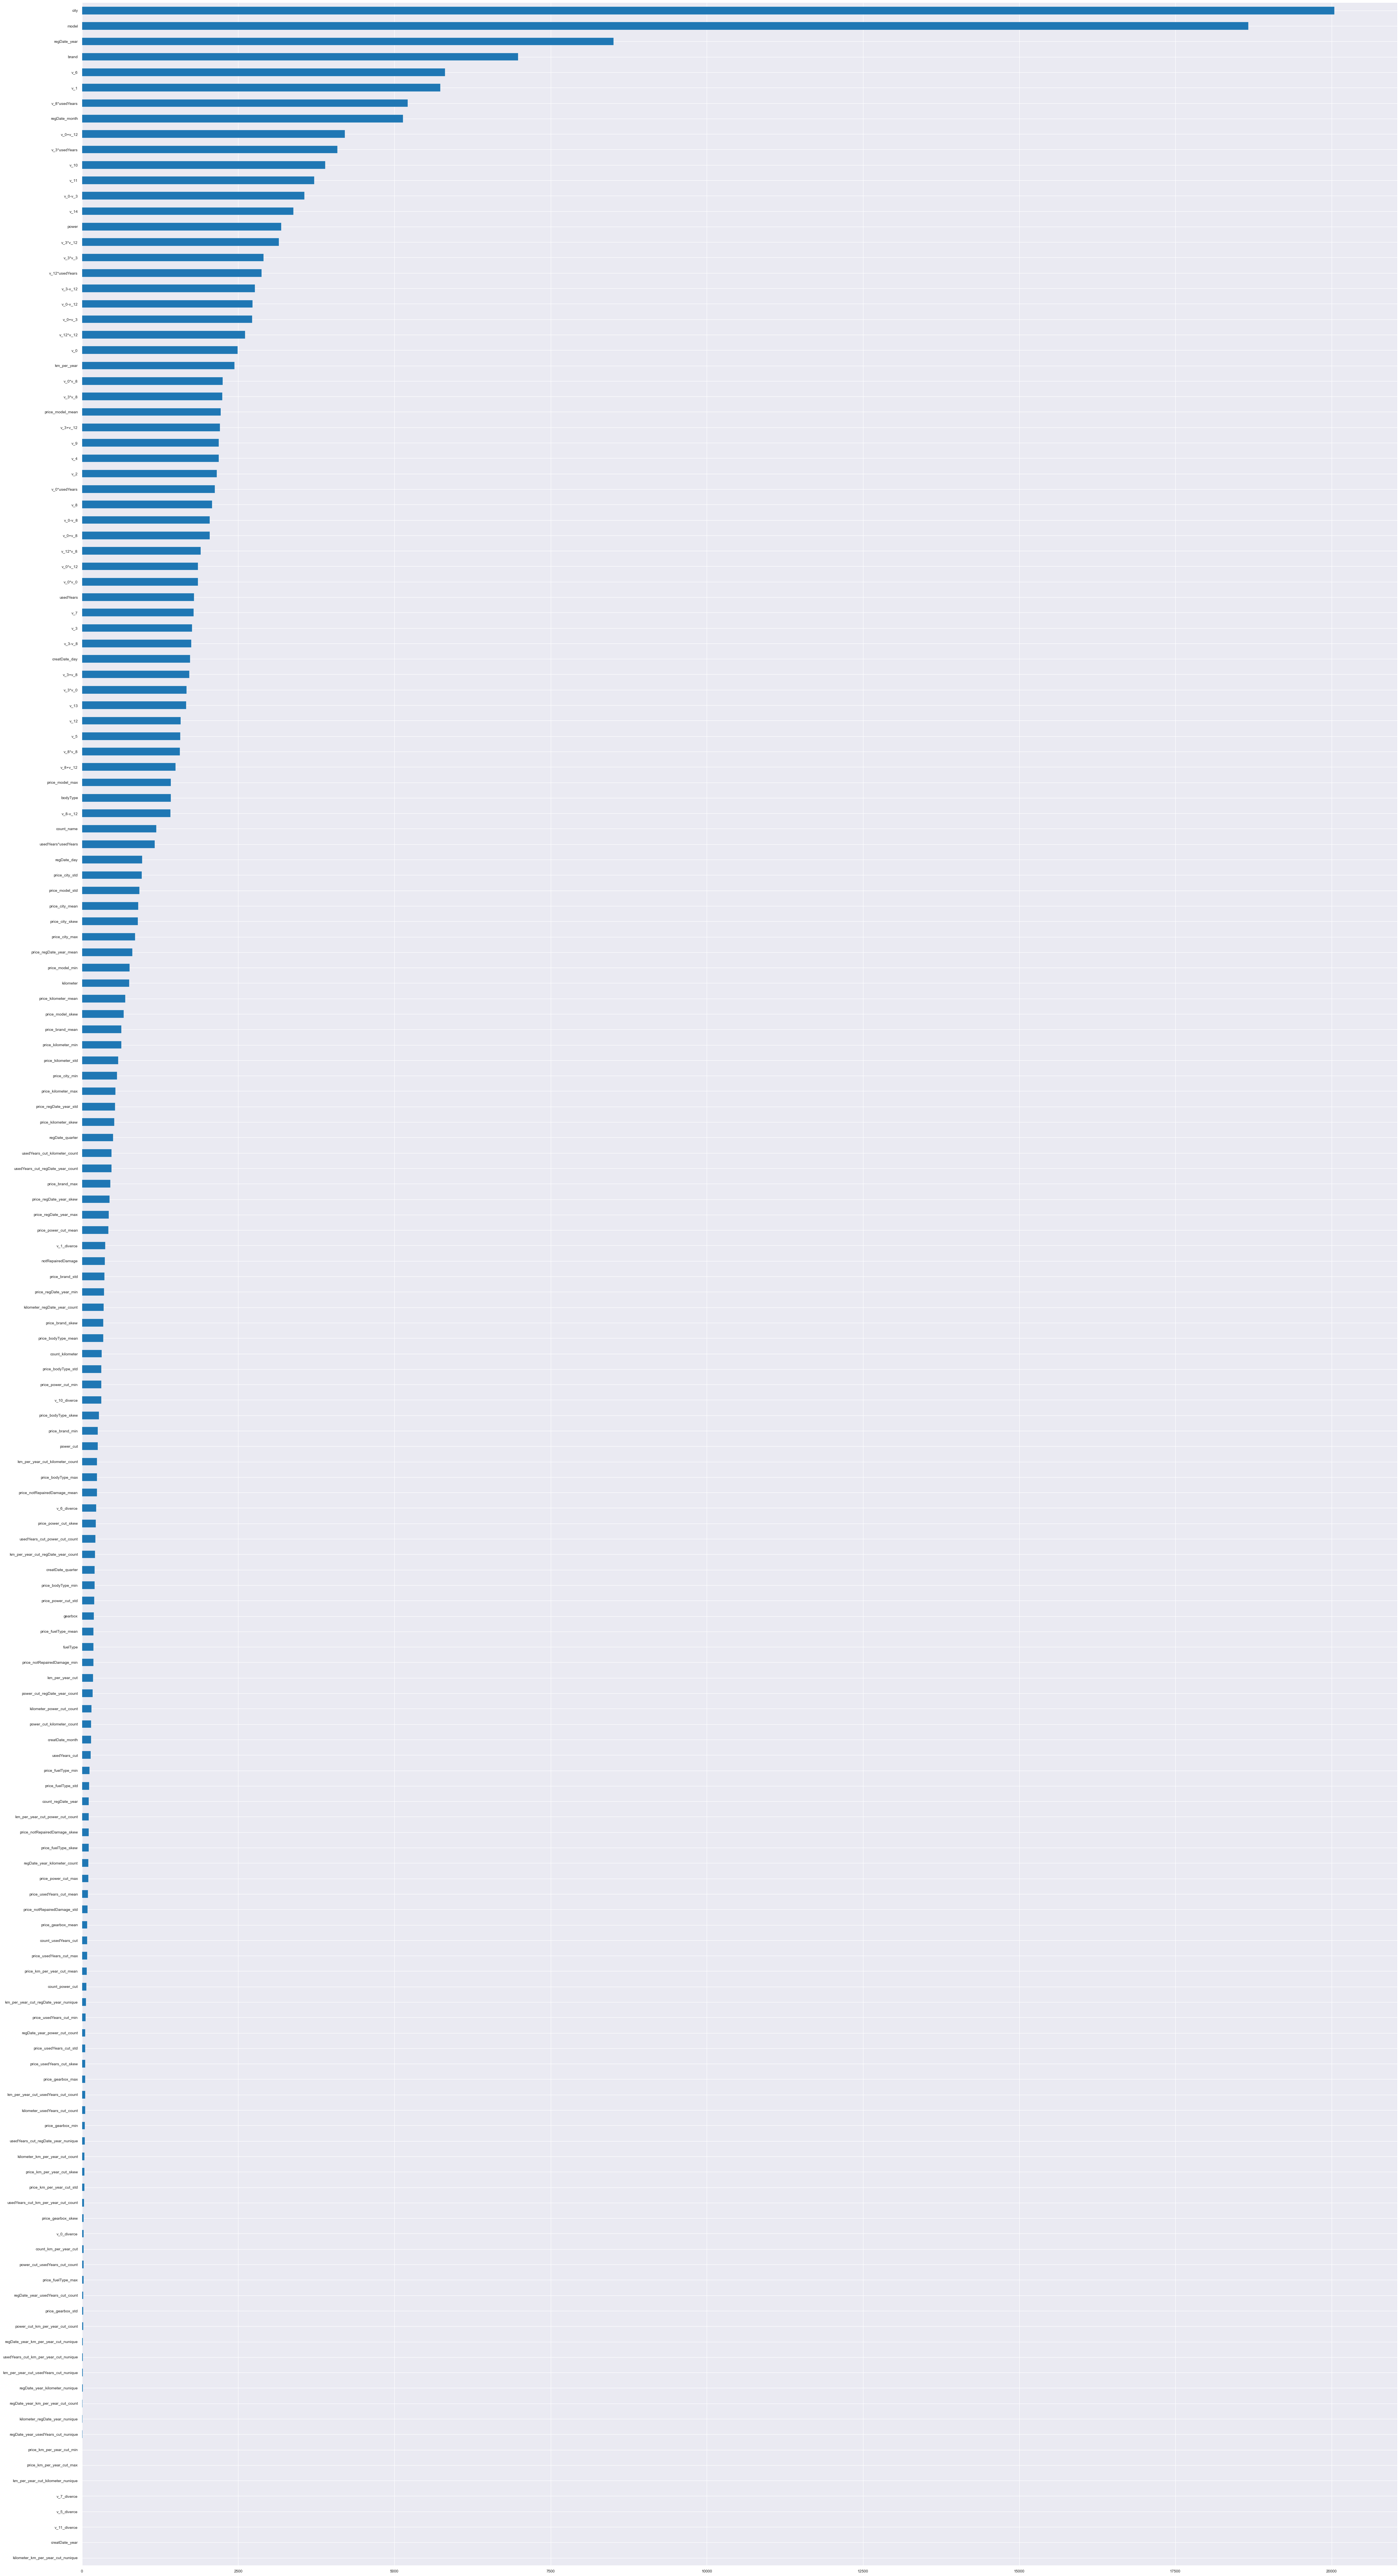

In [62]:
plt.figure(figsize=(60, 120))
feat_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
feat_importance.sort_values(ascending=True).plot(kind='barh')

In [63]:
feat_importance.sort_values(ascending=False)

city                                     20048
model                                    18666
regDate_year                              8507
brand                                     6980
v_6                                       5813
v_1                                       5737
v_8*usedYears                             5211
regDate_month                             5138
v_0+v_12                                  4208
v_3*usedYears                             4091
v_10                                      3895
v_11                                      3718
v_0-v_3                                   3559
v_14                                      3386
power                                     3189
v_3*v_12                                  3153
v_3*v_3                                   2904
v_12*usedYears                            2876
v_3-v_12                                  2767
v_0-v_12                                  2728
v_0+v_3                                   2724
v_12*v_12    

In [64]:
drop_feat = ['kilometer_regDate_year_nunique', 'regDate_year_usedYears_cut_nunique',
             'price_km_per_year_cut_min', 'price_km_per_year_cut_max',
             'km_per_year_cut_kilometer_nunique', 'v_7_diverce', 'v_5_diverce',
             'v_11_diverce', 'creatDate_year', 'kilometer_km_per_year_cut_nunique']

X_train_choiced = X_train.drop(drop_feat, axis=1)
test_data_chioced = test_data.drop(drop_feat, axis=1)

In [79]:
choosed_feature = X_train_choiced.columns
choosed_cat_feature = []
for fea in cat_feature:
    if fea in choosed_feature:
        choosed_cat_feature.append(fea)

choosed_cat_feature.extend(['km_per_year_cut', 'usedYears_cut'])

In [72]:
%%time

def lgb_bayesian(n_estimators,
                 learning_rate,
                 max_depth,
                 subsample,
                 colsample_bytree,
                 min_child_samples,
                 min_child_weight,
                 reg_alpha,
                 reg_lambda):
    
    min_child_samples = int(min_child_samples)
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    lgb_model = lgb.LGBMRegressor(
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  learning_rate=learning_rate,
                                  subsample=subsample,
                                  colsample_bytree=colsample_bytree,
                                  reg_alpha=reg_alpha,
                                  reg_lambda=reg_lambda,
                                  min_child_weight=min_child_weight,
                                  min_child_samples=min_child_samples,
                                  objective='mean_absolute_error',
                                  n_jobs=-1,
                                  #device='gpu',
                                  random_state=927)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=927)
    oof_lgb = np.zeros(len(choosed_X_train))
    for train_idx, val_idx in cv.split(choosed_X_train, Y_train):
        lgb_model.random_state += 1
        train_x = choosed_X_train.iloc[train_idx]
        train_y = Y_train.iloc[train_idx]
        val_x = choosed_X_train.iloc[val_idx]
        val_y = Y_train.iloc[val_idx]
    
        lgb_model.fit(train_x, train_y, 
                      eval_set=[(val_x, val_y)],
                      categorical_feature='auto',
                      eval_metric='mean_absolute_error',
                      verbose=0,
                      early_stopping_rounds=200)
    
        oof_lgb[val_idx] = lgb_model.predict(val_x)
        print(f"******lightgbm MAE******: {mean_absolute_error(inv_boxcox(val_y, lamda), inv_boxcox(lgb_model.predict(val_x), lamda))}")
    mae_error = mean_absolute_error(inv_boxcox(Y_train.values, lamda), inv_boxcox(oof_lgb, lamda))
    return -mae_error

lgb_bounds = {'n_estimators': (6000, 8000),
              'learning_rate': (0.02, 0.05),
              'max_depth': (5, 8),
              'subsample': (0.5, 0.7),
              'colsample_bytree': (0.2, 0.4),
              'min_child_samples': (50, 70),
              'min_child_weight': (0.2, 0.4),
              'reg_alpha': (0, 10),
              'reg_lambda': (0, 10)
             }

lgb_bo = BayesianOptimization(lgb_bayesian, lgb_bounds, random_state=927)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    lgb_bo.maximize(init_points=10, n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
******lightgbm MAE******: 467.06666737726556
******lightgbm MAE******: 461.03059564775094
******lightgbm MAE******: 480.14140969400705
******lightgbm MAE******: 480.8932027699751
******lightgbm MAE******: 475.3554048450229
|  1        | -472.9    |  0.3273   |  0.02427  |  6.714    |  67.14    |  0.2975   |  6.681e+0 |  2.843    |  9.951    |  0.6221   |
******lightgbm MAE******: 466.3621728030247
******lightgbm MAE******: 459.31768048130164
******lightgbm MAE******: 477.5841202335364
******lightgbm MAE******: 478.2692161691507
******lightgbm MAE******: 472.6796559014065
|  2        | -470.8    |  0.3896   |  0.03562  |  7.044    |  56.68    |  0.3386   |  6.043e+0 |  3.605    |  1.508    |  0.5423   |
******lightgbm MAE**

******lightgbm MAE******: 471.1730796131071
******lightgbm MAE******: 462.1954306456737
******lightgbm MAE******: 482.16135507385826
******lightgbm MAE******: 484.64241158833056
******lightgbm MAE******: 477.04938589079626
|  19       | -475.4    |  0.387    |  0.02298  |  5.534    |  69.68    |  0.2842   |  7.619e+0 |  2.501    |  1.744    |  0.6823   |
******lightgbm MAE******: 463.5259219897513
******lightgbm MAE******: 457.3635373604724
******lightgbm MAE******: 474.7755839446329
******lightgbm MAE******: 477.49311281204007
******lightgbm MAE******: 471.90174905065334
|  20       | -469.0    |  0.3039   |  0.04722  |  6.588    |  69.47    |  0.3531   |  7.635e+0 |  7.351    |  7.842    |  0.6345   |
CPU times: user 1d 2h 44min 1s, sys: 47min 18s, total: 1d 3h 31min 20s
Wall time: 2h 37min 6s


In [73]:
lgb_bo.max

{'target': -467.3004439293845,
 'params': {'colsample_bytree': 0.4,
  'learning_rate': 0.05,
  'max_depth': 8.0,
  'min_child_samples': 55.922582779187806,
  'min_child_weight': 0.2,
  'n_estimators': 7380.052317744422,
  'reg_alpha': 10.0,
  'reg_lambda': 10.0,
  'subsample': 0.5}}

In [98]:
lgb_model = lgb.LGBMRegressor(n_estimators=7013,
                              colsample_bytree=0.4,
                              subsample=0.5,
                              learning_rate=0.05,
                              max_depth=8,
                              min_child_samples=56,
                              min_child_weight=0.2,
                              reg_alpha=10,
                              reg_lambda=10,
                              objective='mean_absolute_error',
                              n_jobs=-1,
                              random_state=927)

cv = KFold(n_splits=5, shuffle=True, random_state=927)
# 为了后面的stacking做准备
oof_lgb = np.zeros(len(choosed_X_train))
pred_lgb = np.zeros(len(choosed_test_data))
for train_idx, val_idx in cv.split(choosed_X_train, Y_train):
    lgb_model.random_state += 1
    train_x = choosed_X_train.iloc[train_idx]
    train_y = Y_train.iloc[train_idx]
    val_x = choosed_X_train.iloc[val_idx]
    val_y = Y_train.iloc[val_idx]
    
    lgb_model.fit(train_x, train_y, 
                  eval_set=[(val_x, val_y)],
                  categorical_feature='auto',
                  eval_metric='mean_absolute_error',
                  verbose=0,
                  early_stopping_rounds=200)
    
    oof_lgb[val_idx] = lgb_model.predict(val_x)
    pred_lgb += lgb_model.predict(choosed_test_data) / cv.n_splits

print(f"lightgbm CV score(mae): {mean_absolute_error(inv_boxcox(Y_train.values, lamda), inv_boxcox(oof_lgb, lamda))}")

lightgbm CV score(mae): 468.1062430267613


In [129]:
result = pd.read_csv("used_car_sample_submit.csv")

In [130]:
result['price'] = list(pred_lgb)
result['price'] = result['price'].apply(lambda x: inv_boxcox(x, lamda))

In [131]:
result.head(10)

SaleID         price
0  150000   1272.425342
1  150001   1996.821600
2  150002   8378.763748
3  150003   1144.301367
4  150004   1974.616510
5  150005   1120.203357
6  150006    441.625836
7  150007   3381.069508
8  150008  13567.790934
9  150009    605.162386

In [102]:
result.to_csv("output/single_lightgbm_0928.csv", index=False)

In [157]:
result = pd.read_csv("output/single_lightgbm_0928.csv")

In [158]:
result['price'] = result['price'].apply(lambda x: round(x, 2))

In [159]:
result.head()

SaleID    price
0  150000  1272.43
1  150001  1996.82
2  150002  8378.76
3  150003  1144.30
4  150004  1974.62

In [160]:
result.to_csv("output/single_lightgbm_round2_0928.csv")